Script for Site Selection Process:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
from shapely.geometry import Point
import pyproj
from pyproj import Transformer
import sklearn
from sklearn.cluster import DBSCAN
import numpy as np

In [2]:
# Set the working directory
# Define file path
crash_file_path = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_crash.xlsx"

# Load the Excel file
df = pd.read_excel(crash_file_path, engine="openpyxl")

# Display the first few rows
print(df.head())

   Crash ID         Degree of crash Degree of crash - detailed  \
0   1192032                  Injury             Serious Injury   
1   1193569                  Injury            Moderate Injury   
2   1193930  Non-casualty (towaway)     Non-casualty (towaway)   
3   1194727  Non-casualty (towaway)     Non-casualty (towaway)   
4   1195895                  Injury         Minor/Other Injury   

   Reporting year  Year of crash Month of crash Day of week of crash  \
0            2019           2019        January             Thursday   
1            2019           2019       February            Wednesday   
2            2019           2019       February             Thursday   
3            2019           2019          March               Monday   
4            2019           2019          March             Saturday   

  Two-hour intervals Street of crash Street type  ...  \
0      12:00 - 13:59            HUME         HWY  ...   
1      16:00 - 17:59          QUARRY          RD  ...   

In [ ]:
#NSW road crash data 2019-2023
import pandas as pd
# Define file paths
excel_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_crash.xlsx"
csv_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_crash_pedestrian.csv"

# Load Excel file
crash_df = pd.read_excel(excel_file, engine="openpyxl")

# Create mask for rows where ANY column contains "pedestrian" (case-insensitive)
mask_include = crash_df.astype(str).apply(lambda x: x.str.contains("pedestrian", case=False, na=False)).any(axis=1)

# Create exclusion mask: rows with "Pedestrian refuge" in any column
mask_exclude = crash_df.astype(str).apply(lambda x: x.str.contains("pedestrian refuge", case=False, na=False)).any(axis=1)

# Combine: include mask AND NOT exclude mask
final_mask = mask_include & ~mask_exclude

# Filter the DataFrame
pedestrian_df = crash_df[final_mask]

# Save filtered data to CSV
pedestrian_df.to_csv(csv_file, index=False)

print(f"Filtered CSV saved: {csv_file}")
print(f"Total rows (pedestrian-related, excluding 'Pedestrian refuge'): {len(pedestrian_df)}")


Filtered CSV saved: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_crash_pedestrian.csv
Total rows (pedestrian-related, excluding 'Pedestrian refuge'): 4838


In [ ]:
#traffic unit CSV
import pandas as pd

# Define file paths
excel_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_traffic_unit.csv"
csv_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_traffic_unit_pedestrian.csv"

# Load the traffic unit CSV
tu_df = pd.read_csv(excel_file)

# Create mask for rows where ANY column contains "pedestrian" (case-insensitive)
mask = tu_df.astype(str).apply(lambda x: x.str.contains("pedestrian", case=False, na=False)).any(axis=1)

# Filter the DataFrame
pedestrian_df = tu_df[mask]

# Save filtered data to new CSV
pedestrian_df.to_csv(csv_file, index=False)

print(f"Filtered CSV saved: {csv_file}")
print(f"Total rows with 'pedestrian' in any column: {len(pedestrian_df)}")


Filtered CSV saved: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_traffic_unit_pedestrian.csv
Total rows with 'pedestrian' in any column: 5318


In [ ]:
#merged two datasets to find pedestrian crashes only and matching crash IDs
import pandas as pd

# File paths
crash_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_crash_pedestrian.csv"
traffic_unit_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_traffic_unit_pedestrian.csv"

# Output file path
merged_file = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian.csv"

# Load the two CSV files
crash_df = pd.read_csv(crash_file)
traffic_unit_df = pd.read_csv(traffic_unit_file)

# Merge using Crash ID (adjust the column name if necessary)
merged_df = pd.merge(crash_df, traffic_unit_df, on="Crash ID", how="outer", suffixes=("_crash", "_unit"))

# Save merged data
merged_df.to_csv(merged_file, index=False)

print(f"Merged file saved: {merged_file}")
print(f"Rows in merged file: {len(merged_df)}")
print(f"Columns in merged file: {len(merged_df.columns)}")


Merged file saved: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian.csv
Rows in merged file: 5319
Columns in merged file: 59


In [ ]:
#filter for X-Intersections only and remove rows with BOTH Longitude and Latitude missing
import pandas as pd

# File path
file_path = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian.csv"

# Load CSV
df = pd.read_csv(file_path)

# Show column names (optional)
print("Columns:", df.columns.tolist())

# Filter: Keep only rows where "Type of location" is "X-Intersection"
df = df[df["Type of location"].str.strip().str.lower() == "x-intersection"]

# Remove rows where BOTH Longitude and Latitude are missing
cleaned_df = df[~(df["Longitude"].isna() & df["Latitude"].isna())]

# Count removed rows
removed_rows = len(df) - len(cleaned_df)
print(f"Removed rows with BOTH Longitude and Latitude missing: {removed_rows}")

# Save cleaned data to a new file
output_file = file_path.replace(".csv", "_XIntersection_cleaned.csv")
cleaned_df.to_csv(output_file, index=False)

print(f"Cleaned file saved: {output_file}")
print(f"Total rows after filtering: {len(cleaned_df)}")


Columns: ['Crash ID', 'Degree of crash', 'Degree of crash - detailed', 'Reporting year', 'Year of crash', 'Month of crash', 'Day of week of crash', 'Two-hour intervals', 'Street of crash', 'Street type', 'Distance', 'Direction', 'Identifying feature', 'Identifying feature type', 'Town', 'Route no.', 'School zone location', 'School zone active', 'Type of location', 'Latitude', 'Longitude', 'LGA', 'Urbanisation', 'Conurbation 1', 'Alignment', 'Primary permanent feature', 'Primary temporary feature', 'Primary hazardous feature', 'Street lighting', 'Road surface', 'Surface condition', 'Weather', 'Natural lighting', 'Signals operation', 'Other traffic control', 'Speed limit', 'Road classification (admin)', 'RUM - code', 'RUM - description', 'DCA - code', 'DCA - description', 'DCA supplement', 'First impact type', 'Key TU type', 'Other TU type', 'No. of traffic units involved', 'No. killed', 'No. seriously injured', 'No. moderately injured', 'No. minor-other injured', 'Traffic unit ID', 'TU 

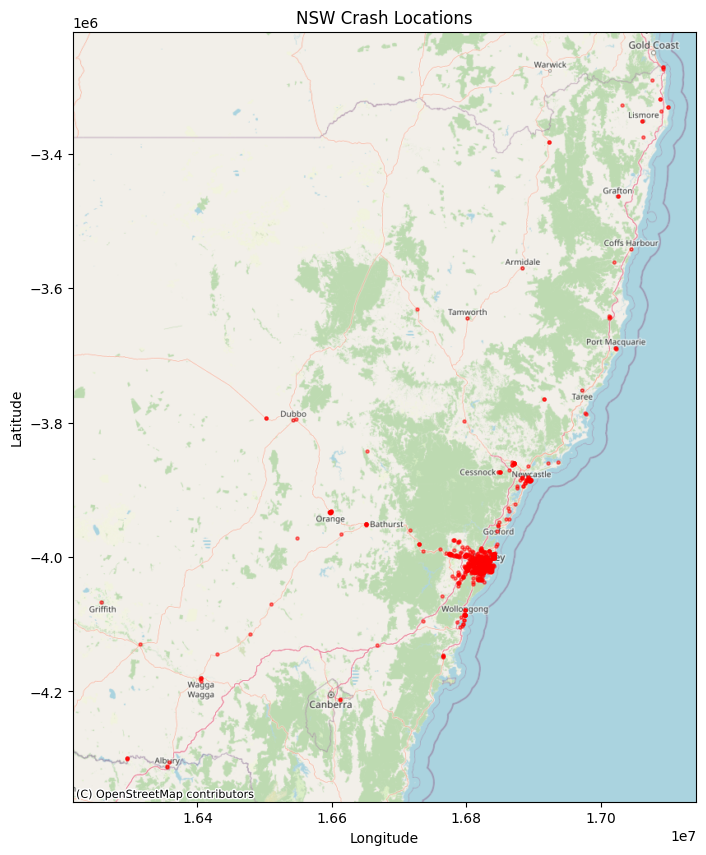

In [ ]:
# plot locations of crashes (NSW)
# Ensure latitude and longitude columns exist
lat_col = 'Latitude'  
lon_col = 'Longitude'

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(cleaned_df, geometry=gpd.points_from_xy(cleaned_df[lon_col], cleaned_df[lat_col]), crs="EPSG:4326")

# Convert to Web Mercator for mapping
gdf = gdf.to_crs(epsg=3857)

# Plot crashes on a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set labels
ax.set_title("NSW Crash Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


plt.show()

Total crashes in City of Sydney bounding box: 214


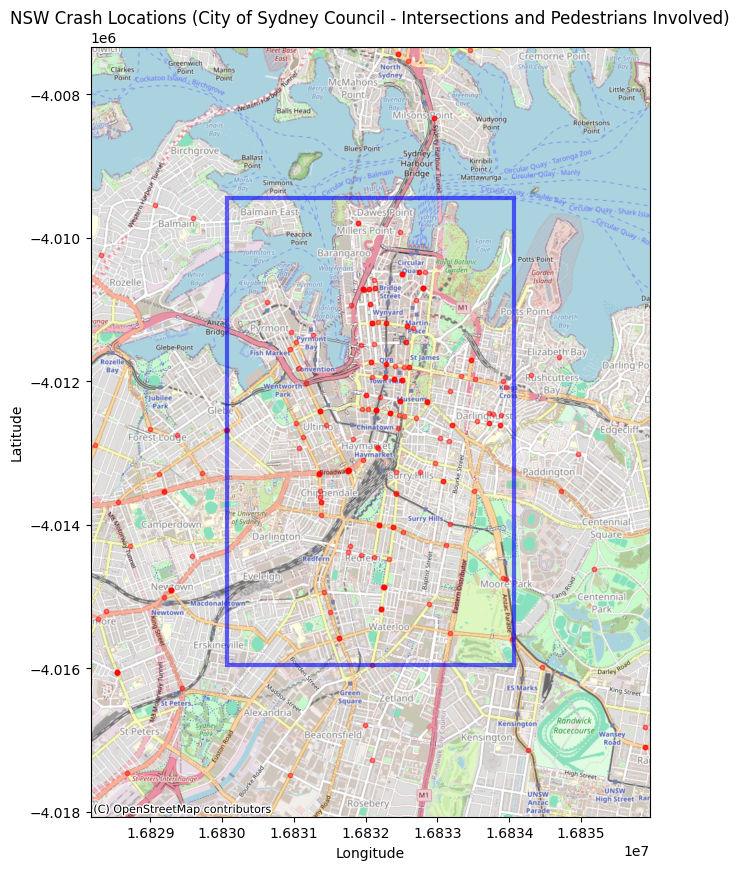

List of plotted locations saved: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned_CitySydneySubset.csv
Total number of crashes in City of Sydney Council area: 214
Converted CSV to Excel: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned_CitySydneySubset.xlsx
Plot saved as image: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned_CitySydneySubset_plot.png


In [ ]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Rectangle

# File path (already filtered to X-Intersections and cleaned)
file_path = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned.csv"

# Load cleaned file
cleaned_df = pd.read_csv(file_path)

# Columns for coordinates
lon_col = "Longitude"
lat_col = "Latitude"

# Approximate bounding box for City of Sydney Council area
min_lon, min_lat = 151.170, -33.920   # South-west corner
max_lon, max_lat = 151.240, -33.840   # North-east corner

# Filter based on approximate bounds
city_sydney_df = cleaned_df[
    (cleaned_df[lon_col] >= min_lon) & 
    (cleaned_df[lon_col] <= max_lon) & 
    (cleaned_df[lat_col] >= min_lat) & 
    (cleaned_df[lat_col] <= max_lat)
]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(city_sydney_df, geometry=gpd.points_from_xy(city_sydney_df[lon_col], city_sydney_df[lat_col]), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# Convert bounding box to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
min_x, min_y = transformer.transform(min_lon, min_lat)
max_x, max_y = transformer.transform(max_lon, max_lat)

# Calculate center of bounding box
center_x = (min_x + max_x) / 2
center_y = (min_y + max_y) / 2

# Define size of the square (in meters, since EPSG:3857)
# square_size = 1000  # 1 km side length
# square_half = square_size / 2

# Plot crashes
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=10, color='red', alpha=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857")

# Zoom into the bounding box
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

from matplotlib.patches import Rectangle

# Adjustable rectangle parameters
rect_width = 4000      # width in meters (e.g., East-West span)
rect_height = 6500     # height in meters (e.g., North-South span)
line_color = 'blue'    # outline color
line_width = 3         # line thickness
fill_color = 'none'    # fill (transparent)
alpha_value = 0.6      # transparency

# Calculate half sizes for positioning
half_width = rect_width / 2
half_height = rect_height / 2

# Draw rectangle (centered at bounding box center)
rectangle = Rectangle(
    (center_x - half_width, center_y - half_height),  # bottom-left corner
    rect_width,   # width
    rect_height,  # height
    linewidth=line_width,
    edgecolor=line_color,
    facecolor=fill_color,
    alpha=alpha_value
)

# Add to plot
ax.add_patch(rectangle)

# Set labels and title
ax.set_title("NSW Crash Locations (City of Sydney Council - Intersections and Pedestrians Involved)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print(f"Total crashes in City of Sydney bounding box: {city_sydney_df.shape[0]}")

plt.show()

# Save list of plotted locations to CSV
output_csv = file_path.replace(".csv", "_CitySydneySubset.csv")
city_sydney_df.to_csv(output_csv, index=False)
print(f"List of plotted locations saved: {output_csv}")

#count number of crashes in City of Sydney Council area
crash_count = city_sydney_df.shape[0]
print(f"Total number of crashes in City of Sydney Council area: {crash_count}")

#convert csv filt to excel
output_excel = output_csv.replace(".csv", ".xlsx")
city_sydney_df.to_excel(output_excel, index=False)
print(f"Converted CSV to Excel: {output_excel}")

#download plot 
# Save the plot as an image file
output_image = file_path.replace(".csv", "_CitySydneySubset_plot.png")
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Plot saved as image: {output_image}")

In [ ]:
# # Rectangle boundaries in EPSG:3857
rect_min_x = center_x - half_width
rect_max_x = center_x + half_width
rect_min_y = center_y - half_height
rect_max_y = center_y + half_height

# Filter gdf for points inside the rectangle
locations_in_rect = gdf[
    (gdf.geometry.x >= rect_min_x) &
    (gdf.geometry.x <= rect_max_x) &
    (gdf.geometry.y >= rect_min_y) &
    (gdf.geometry.y <= rect_max_y)
]

# Save to CSV
output_csv_rect = file_path.replace(".csv", "_CitySydneySubset_Rectangle.csv")
locations_in_rect.drop(columns="geometry").to_csv(output_csv_rect, index=False)

print(f"List of locations within rectangle saved: {output_csv_rect}")
print(f"Total locations inside rectangle: {len(locations_in_rect)}")

List of locations within rectangle saved: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned_CitySydneySubset_Rectangle.csv
Total locations inside rectangle: 168


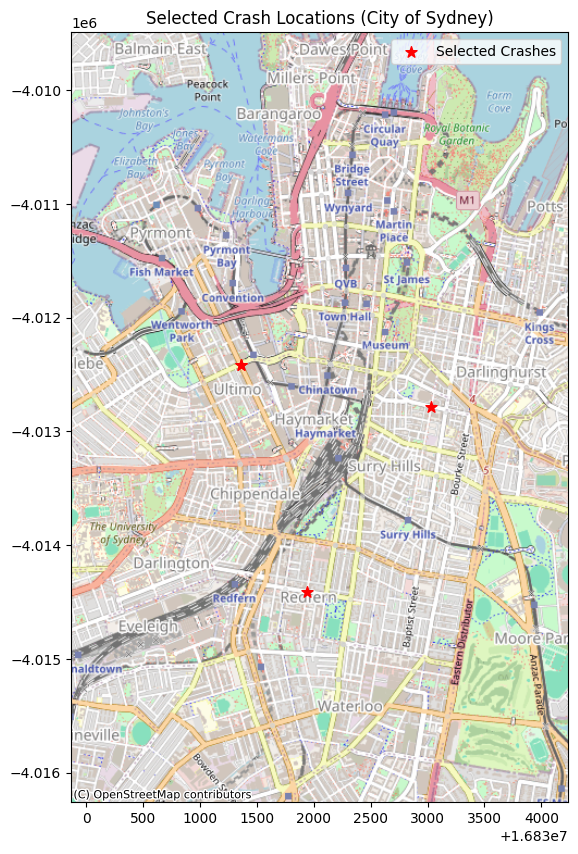

In [ ]:
# plot selected locations by CrashID
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# === Load dataset already filtered to City of Sydney ===
file_path = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_XIntersection_cleaned_CitySydneySubset_Rectangle.csv"
city_sydney_df = pd.read_csv(file_path)

# Columns
lon_col = "Longitude"
lat_col = "Latitude"

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    city_sydney_df,
    geometry=gpd.points_from_xy(city_sydney_df[lon_col], city_sydney_df[lat_col]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# SELECT LOCATIONS BY CrashID after checking geometry manually
# Replace with the Crash IDs you want to plot
selected_ids = [
                # 1297149,
                1314067,
                # 1284858,
                1295351,
                1301024
                    ]

five_locations = gdf[gdf["Crash ID"].isin(selected_ids)]

# PLOT
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crashes in light grey
gdf.plot(ax=ax, markersize=8, color="lightgrey", alpha=0.4)

# Highlight the selected crashes
five_locations.plot(ax=ax, markersize=70, color="red", marker="*", label="Selected Crashes")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857")

# Add labels
ax.set_title("Selected Crash Locations (City of Sydney)")
ax.legend()

plt.show()

# SAVE OUTPUTS
five_locations.to_csv(file_path.replace(".csv", "_CitySydneySubset_Selected5.csv"), index=False)
output_image = file_path.replace(".csv", "_CitySydneySubset_plot.png")
fig.savefig(output_image, dpi=300, bbox_inches="tight")



In [16]:
# check walkcount for selected sites
import pandas as pd

# Load file
file_path = '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/walkcount_weekday_ranked.csv'
df = pd.read_csv(file_path)


# Define include + exclude keywords
include_keywords = ["Redfern Street", "Young Street", "Harris Street", "Campbell Street", "Phillip Street"]
exclude_keywords = ["Railway", "George", "Bent", "Quarry", "Elizabeth"]

# --- Include filter ---
include_mask = df.apply(
    lambda row: row.astype(str).str.contains('|'.join(include_keywords), case=False, na=False),
    axis=1
).any(axis=1)

# --- Exclude filter ---
exclude_mask = df.apply(
    lambda row: row.astype(str).str.contains('|'.join(exclude_keywords), case=False, na=False),
    axis=1
).any(axis=1)

# Apply both: include AND NOT exclude
filtered_df = df[include_mask & ~exclude_mask]

# Save filtered file
output_file = file_path.replace(".csv", "_filtered.csv")
filtered_df.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")
print(f"Total rows after filtering: {filtered_df.shape[0]}")

avg_counts = filtered_df.groupby("Location")[["Total_Daytime_Count", "Average_Daytime_Count", "Time_0800", "Time_0900", "Time_1200", "Time_1300"]].mean().reset_index()
print(avg_counts)

avg_output_file = file_path.replace(".csv", "_avgByLocation.csv")
avg_counts.to_csv(avg_output_file, index=False)

print(f"Average counts per Location saved to: {avg_output_file}")

Filtered rows saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/walkcount_weekday_ranked_filtered.csv
Total rows after filtering: 158
         Location  Total_Daytime_Count  Average_Daytime_Count   Time_0800  \
0    Crown Street          6942.000000             385.666667  442.200000   
1   Harris Street          4124.926829             229.162602  253.829268   
2  Redfern Street          6858.750000             381.041667  456.450000   
3    Young Street          8016.000000             445.333333  745.125000   

    Time_0900   Time_1200   Time_1300  
0  364.500000  523.800000  528.600000  
1  292.829268  352.243902  378.512195  
2  469.950000  451.950000  511.950000  
3  687.750000  737.250000  598.875000  
Average counts per Location saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/walkcount_weekday_ranked_avgByLocation.csv


In [ ]:
"/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/crash stats/nsw_road_crash_data_2019-2023_merged_pedestrian_cleaned.csv"

In [ ]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^